In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.OxfordIIITPet(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

In [9]:
def calc_features(encoder, items_dict):
    with torch.no_grad():
        label_ids = []
        features_cuda = []
        cls_features_cuda = []
        for label_id in tqdm(range(len(cls_names_sorted))):
            items = items_dict.pop(label_id)
            label_ids.append([label_id] * len(items))
            class_embeddings = encoder(items)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        features = torch.vstack(features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, features, features_cuda, cls_features_cuda, masked_similarity

In [10]:
def encode_text(texts):
    with torch.no_grad():
        return model.encode_text(clip.tokenize(texts).to(device))

In [11]:
# Create template text features
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(encode_text, template_label_texts_list)

100%|██████████| 37/37 [00:00<00:00, 47.80it/s]


In [12]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/pets_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts_file = json.load(f)

In [13]:
# Mapping between CuPL and cls_name
special_class_mapping = {
}

In [14]:
# Lookup CuLP prompts from cls_name
original_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts_file.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name).replace(' ', '_').lower()
    if cls_name not in dataset_test.classnames:
        continue
    original_gpt3_prompts[cls_name] = texts

In [15]:
# Create original gpt3 text features
original_gpt3_label_texts_list = {label_id: original_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
original_gpt3_label_ids, original_gpt3_text_features, original_gpt3_text_features_cuda, original_gpt3_cls_features_cuda, original_gpt3_masked_similarity = calc_features(encode_text, original_gpt3_label_texts_list)

100%|██████████| 37/37 [00:00<00:00, 155.87it/s]


In [16]:
# Hyperparameters for filtering outliers in gpt3 texts

# Minimum mean similarity
similarity_mean_threshold = 0.7

# Minimum similarity to be counted as dissimilar
similarity_count_threshold = 0.65
# Filter if it is dissimilar from more than (1-ratio) of the other texts
similarity_count_ratio = 0.5

In [17]:
# Filter out outliers in gpt3 text features
with torch.no_grad():
    # Remove duplicates
    unique_gpt3_prompts = {label_id: list(dict.fromkeys(original_gpt3_prompts[cls_name])) for label_id, cls_name in enumerate(cls_names_sorted)}
    _, _, unique_gpt3_text_features_cuda, _, _ = calc_features(encode_text, unique_gpt3_prompts.copy())

    unique_gpt3_text_similarity = [(features_cuda @ features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy() for features_cuda in unique_gpt3_text_features_cuda]
    unique_gpt3_text_similarity_mean = [np.nanmean(similarity, axis=0) for similarity in unique_gpt3_text_similarity]
    unique_gpt3_text_similarity_count_mean = [(similarity >= similarity_count_threshold).mean(axis=0) for similarity in unique_gpt3_text_similarity]
    filtered_gpt3_prompts = {label_id: [text for text, similarity_mean, similarity_count in zip(texts, similarity_means, similarity_counts) if similarity_mean >= similarity_mean_threshold and similarity_count >= similarity_count_ratio] for (label_id, texts), similarity_means, similarity_counts in zip(unique_gpt3_prompts.items(), unique_gpt3_text_similarity_mean, unique_gpt3_text_similarity_count_mean)}
    # Print filtered prompts
    outlier_gpt3_prompts = {label_id: [text for text, similarity_mean, similarity_count in zip(texts, similarity_means, similarity_counts) if not (similarity_mean >= similarity_mean_threshold and similarity_count >= similarity_count_ratio)] for (label_id, texts), similarity_means, similarity_counts in zip(unique_gpt3_prompts.items(), unique_gpt3_text_similarity_mean, unique_gpt3_text_similarity_count_mean)}
    top_filtered_label_id = None
    top_filtered_count = 0
    for label_id, texts in outlier_gpt3_prompts.items():
        filtered_count = len(texts)
        if filtered_count != 0:
            print(f'Filtered {filtered_count} outliers for ({label_id}){cls_names_sorted[label_id]}')
            print(texts)
            print()
            if filtered_count > top_filtered_count:
                top_filtered_count = filtered_count
                top_filtered_label_id = label_id

100%|██████████| 37/37 [00:00<00:00, 186.83it/s]


Filtered 1 outliers for (7)bombay
['.']

Filtered 1 outliers for (12)english_cocker_spaniel
['A small to medium sized dog with a long, floppy ears, and a silky coat that is often wavy or curly.']

Filtered 1 outliers for (18)keeshond
['Keeshonden are Dutch Barge Dogs, a type of canine that was historically used for hunting and guarding.']

Filtered 1 outliers for (27)russian_blue
['Russians Blues are elegantly proportioned cats with a long, fine-boned body, thick fur, and large expressive eyes.']

Filtered 2 outliers for (28)saint_bernard
['A St.', "A 'saint bernard' is a type of pet that is typically large and furry."]

Filtered 1 outliers for (30)scottish_terrier
['Image result for pictures of scottish terriersA Scottie typically has a black, gray, or brindled coat with a white chest and underparts.']



Class: (28)saint_bernard
(3)A St.
(18)A 'saint bernard' is a type of pet that is typically large and furry.


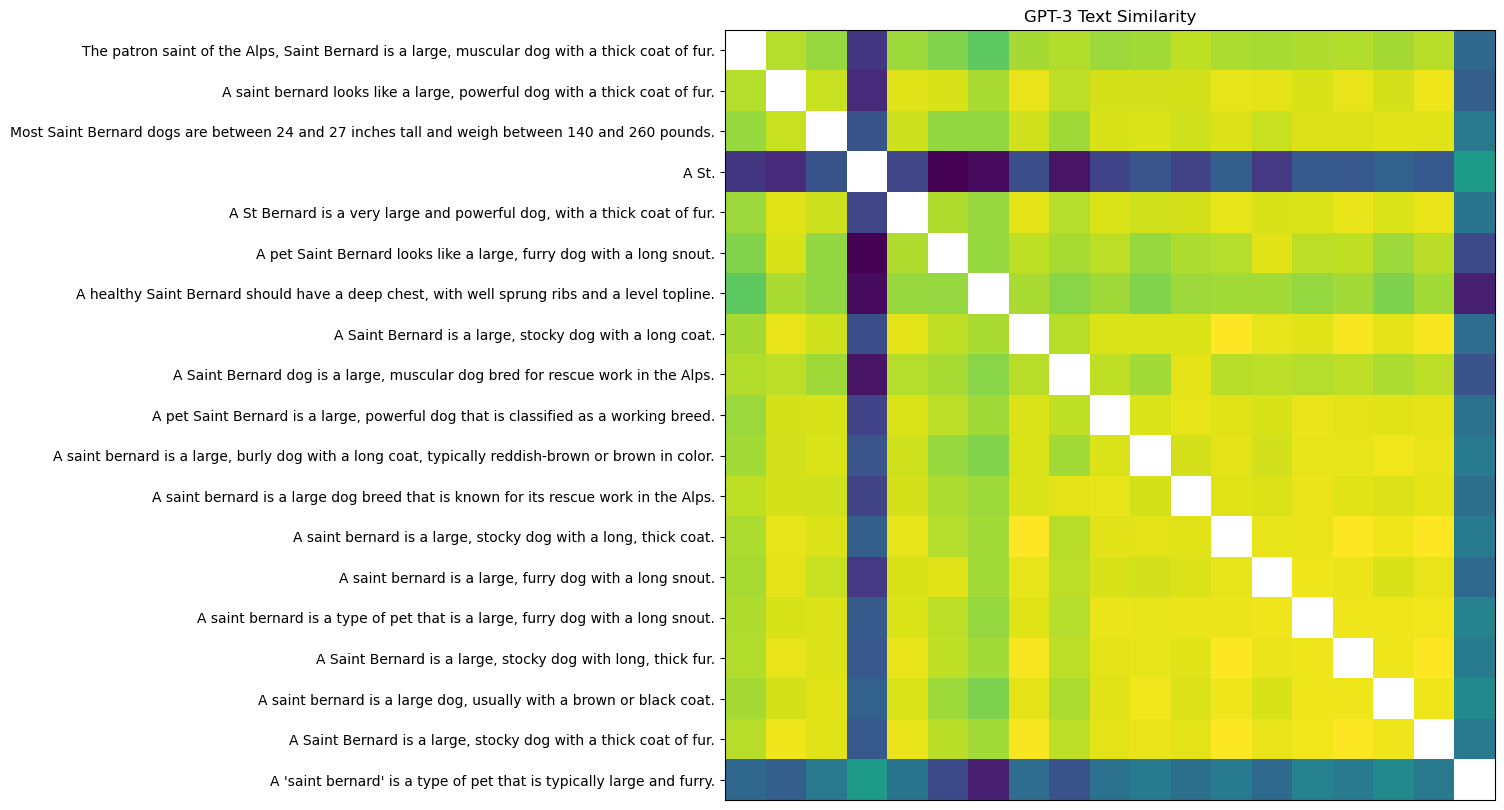

In [18]:
# Visualize dis-similarities of outliers
print(f'Class: ({top_filtered_label_id}){cls_names_sorted[top_filtered_label_id]}')
ylabels = unique_gpt3_prompts[top_filtered_label_id]
for text in outlier_gpt3_prompts[top_filtered_label_id]:
    print(f'({ylabels.index(text)}){text}')
plt.figure(figsize=(12, 10))
plt.imshow(unique_gpt3_text_similarity[top_filtered_label_id])
plt.xticks([])
plt.yticks(np.arange(0, len(ylabels)), ylabels)
plt.title('GPT-3 Text Similarity')
plt.show()

In [19]:
# Create filtered gpt3 text features
filtered_gpt3_label_texts_list = {label_id: filtered_gpt3_prompts[label_id] for label_id in range(len(cls_names_sorted))}
filtered_gpt3_label_ids, filtered_gpt3_text_features, filtered_gpt3_text_features_cuda, filtered_gpt3_cls_features_cuda, filtered_gpt3_masked_similarity = calc_features(encode_text, filtered_gpt3_label_texts_list)

100%|██████████| 37/37 [00:00<00:00, 190.34it/s]


In [20]:
def encode_images(imgs):
    with torch.no_grad():
        return model.encode_image(torch.stack([preprocess(img) for img in imgs]).to(device))

In [21]:
# Create image features
imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)
img_label_ids, _, img_features_cuda, _, img_masked_similarity = calc_features(encode_images, imgs_grouped)

100%|██████████| 37/37 [00:29<00:00,  1.26it/s]


In [22]:
import sklearn.metrics

def calc_clip_pred(label_ids, img_features_cuda, text_features_cuda):
    with torch.no_grad():
        if type(text_features_cuda) == list:  # list of tensors
            logits = torch.vstack([(img_features_cuda @ embeddings.T).mean(dim=-1) for embeddings in text_features_cuda]).T
        else:
            logits = img_features_cuda @ text_features_cuda.T
        pred = logits.argmax(dim=-1).cpu().numpy()

        return (pred == label_ids).mean(), sklearn.metrics.confusion_matrix(label_ids, pred, labels=np.arange(len(cls_names_sorted)), normalize='true')

In [23]:
# Combine template text with gpt3 text features
combined_original_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, original_gpt3_text_features_cuda)]
combined_filtered_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, filtered_gpt3_text_features_cuda)]
combined_original_gpt3_cls_features_cuda = []
combined_filtered_gpt3_cls_features_cuda = []
for class_embeddings in combined_original_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_original_gpt3_cls_features_cuda.append(class_embedding)
for class_embeddings in combined_filtered_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_filtered_gpt3_cls_features_cuda.append(class_embedding)
combined_original_gpt3_cls_features_cuda = torch.vstack(combined_original_gpt3_cls_features_cuda)
combined_filtered_gpt3_cls_features_cuda = torch.vstack(combined_filtered_gpt3_cls_features_cuda)

In [24]:
# Zero-shot classification of CLIP
img_features_stacked_cuda = torch.vstack(img_features_cuda)

cls_name_acc, cls_name_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, cls_name_features_cuda)
template_cls_acc, template_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_cls_features_cuda)
template_text_acc, template_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_text_features_cuda)
original_gpt3_cls_acc, original_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_cls_features_cuda)
original_gpt3_text_acc, original_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_text_features_cuda)
filtered_gpt3_cls_acc, filtered_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_cls_features_cuda)
filtered_gpt3_text_acc, filtered_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_text_features_cuda)
combined_original_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_cls_features_cuda)
combined_original_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_text_features_cuda)
combined_filtered_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_cls_features_cuda)
combined_filtered_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_text_features_cuda)

In [25]:
print(f'Accuracy of CLIP with class names: {cls_name_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (centroid): {template_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (individual avg): {template_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (centroid): {original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (individual avg): {original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (centroid): {filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (individual avg): {filtered_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (centroid): {combined_original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (individual avg): {combined_original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (centroid): {combined_filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (individual avg): {combined_filtered_gpt3_text_acc*100:.2f}%')

Accuracy of CLIP with class names: 80.10%
Accuracy of CLIP with text template (centroid): 87.05%
Accuracy of CLIP with text template (individual avg): 86.40%
Accuracy of CLIP with original GPT-3 text (centroid): 91.11%
Accuracy of CLIP with original GPT-3 text (individual avg): 92.15%
Accuracy of CLIP with filtered GPT-3 text (centroid): 91.41%
Accuracy of CLIP with filtered GPT-3 text (individual avg): 92.18%
Accuracy of CLIP with combined original GPT-3 text (centroid): 88.66%
Accuracy of CLIP with combined original GPT-3 text (individual avg): 87.90%
Accuracy of CLIP with combined filtered GPT-3 text (centroid): 88.63%
Accuracy of CLIP with combined filtered GPT-3 text (individual avg): 87.87%


In [26]:
# Zero-shot classification of CLIP using one text on all images
template_text_individual_features_cuda = list(torch.stack(template_text_features_cuda).permute(1, 0, 2))
template_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in template_text_individual_features_cuda])
original_gpt3_text_individual_features_cuda = list(torch.stack(original_gpt3_text_features_cuda).permute(1, 0, 2))
original_gpt3_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in original_gpt3_text_individual_features_cuda])

In [27]:
print(f'Accuracy of CLIP with text template (one text on all images): mean={template_text_individual_acc.mean()*100:.2f}%, std={template_text_individual_acc.std()}')
print(f'Accuracy of CLIP with original GPT-3 text (one text on all images): mean={original_gpt3_text_individual_acc.mean()*100:.2f}%, std={original_gpt3_text_individual_acc.std()}')

Accuracy of CLIP with text template (one text on all images): mean=84.18%, std=0.03488830081128669
Accuracy of CLIP with original GPT-3 text (one text on all images): mean=87.47%, std=0.017753404124485315


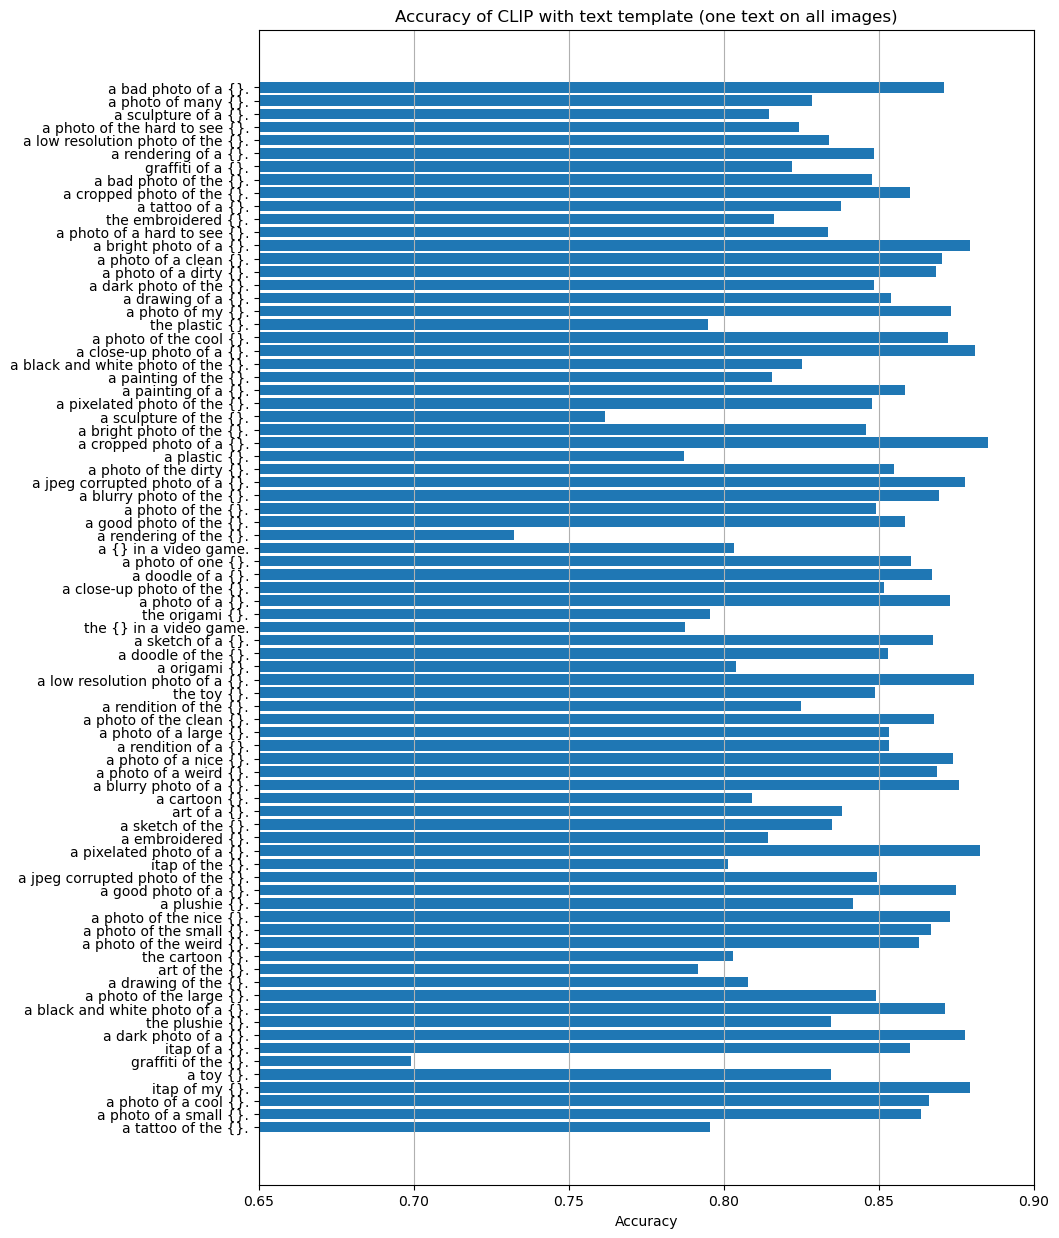

In [28]:
plt.figure(figsize=(10, 15))
plt.barh(np.arange(len(template_text_individual_acc)), template_text_individual_acc, align='center')
plt.yticks(np.arange(len(template_text_individual_acc)), imagenet_templates)
plt.xlabel('Accuracy')
plt.title('Accuracy of CLIP with text template (one text on all images)')
scale = 0.05
plt.xlim(int(template_text_individual_acc.min()/scale)*scale, (int(template_text_individual_acc.max()/scale)+1)*scale)
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

In [29]:
def calc_features_similarity(features1_cuda, features2_cuda):
    with torch.no_grad():
        similarity_cuda = []
        for embeddings1 in features1_cuda:
            if type(features2_cuda) == list:  # list of tensors
                similarity_cuda.append(torch.Tensor([(embeddings1 @ embeddings2.T).mean() for embeddings2 in features2_cuda]))
            else:
                similarity_cuda.append((embeddings1 @ features2_cuda.T).mean(dim=0))

        return torch.vstack(similarity_cuda).cpu().numpy()

In [30]:
# Calculate similarity between image features and text features
img_cls_name_similarity = calc_features_similarity(img_features_cuda, cls_name_features_cuda)
img_template_cls_similarity = calc_features_similarity(img_features_cuda, template_cls_features_cuda)
img_template_text_similarity = calc_features_similarity(img_features_cuda, template_text_features_cuda)
img_original_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, original_gpt3_cls_features_cuda)
img_original_gpt3_text_similarity = calc_features_similarity(img_features_cuda, original_gpt3_text_features_cuda)
img_filtered_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_cls_features_cuda)
img_filtered_gpt3_text_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_text_features_cuda)

In [31]:
def print_top_pairs(similarity, text, *, top=10, xlabel='', ylabel='', coordinates=None):
    # Get the indices of top values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top values
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        if coordinates is None:
            print(f'Rank {idx+1}: ({label1}){ylabel}{cls_names_sorted[label1]} - ({label2}){xlabel}{cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')
        else:
            print(f'Rank {idx+1}: ({label1}){ylabel}(coor={coordinates[label1][0]:.0f},{coordinates[label1][1]:.0f}){cls_names_sorted[label1]} - ({label2}){xlabel}(coor={coordinates[label1][0]:.0f},{coordinates[label1][1]:.0f}){cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')

In [32]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, similarity.shape[0], 5))
    plt.yticks(np.arange(0, similarity.shape[1], 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [33]:
def plot_cm(cm, title):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm)
    plt.xticks(np.arange(0, cm.shape[0], 5))
    plt.yticks(np.arange(0, cm.shape[1], 5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [34]:
def visualize_auto_similarity(masked_similarity, title):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_pairs(np.triu(masked_similarity, k=1), 'similarity')
    plot_similarity(masked_similarity, title_similarity)

In [35]:
def visualize_cross_similarity(similarity, cm, title, xlabel='Text', ylabel='Image'):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title_similarity.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title_similarity.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_pairs(masked_similarity, 'similarity', top=20, xlabel=f'({xlabel})', ylabel=f'({ylabel})')
    plot_similarity(similarity, title_similarity, xlabel=xlabel, ylabel=ylabel)
    masked_cm = cm.copy()
    np.fill_diagonal(masked_cm, np.nan)
    print_top_pairs(masked_cm, 'error rate', top=20, xlabel=f'({xlabel})', ylabel=f'({ylabel})')
    plot_cm(cm, title + ' Confusion Matrix')

Class name similarity mean: 0.56396484375
Class name similarity std: 0.0948486328125
Rank 1: (2)american_pit_bull_terrier - (34)staffordshire_bull_terrier, similarity: 0.8955078125
Rank 2: (1)american_bulldog - (2)american_pit_bull_terrier, similarity: 0.82568359375
Rank 3: (30)scottish_terrier - (36)yorkshire_terrier, similarity: 0.818359375
Rank 4: (10)chihuahua - (24)pomeranian, similarity: 0.79931640625
Rank 5: (3)basset_hound - (4)beagle, similarity: 0.79150390625
Rank 6: (6)birman - (26)ragdoll, similarity: 0.78173828125
Rank 7: (7)bombay - (23)persian, similarity: 0.78076171875
Rank 8: (24)pomeranian - (25)pug, similarity: 0.77392578125
Rank 9: (5)bengal - (7)bombay, similarity: 0.77294921875
Rank 10: (26)ragdoll - (32)siamese, similarity: 0.76708984375


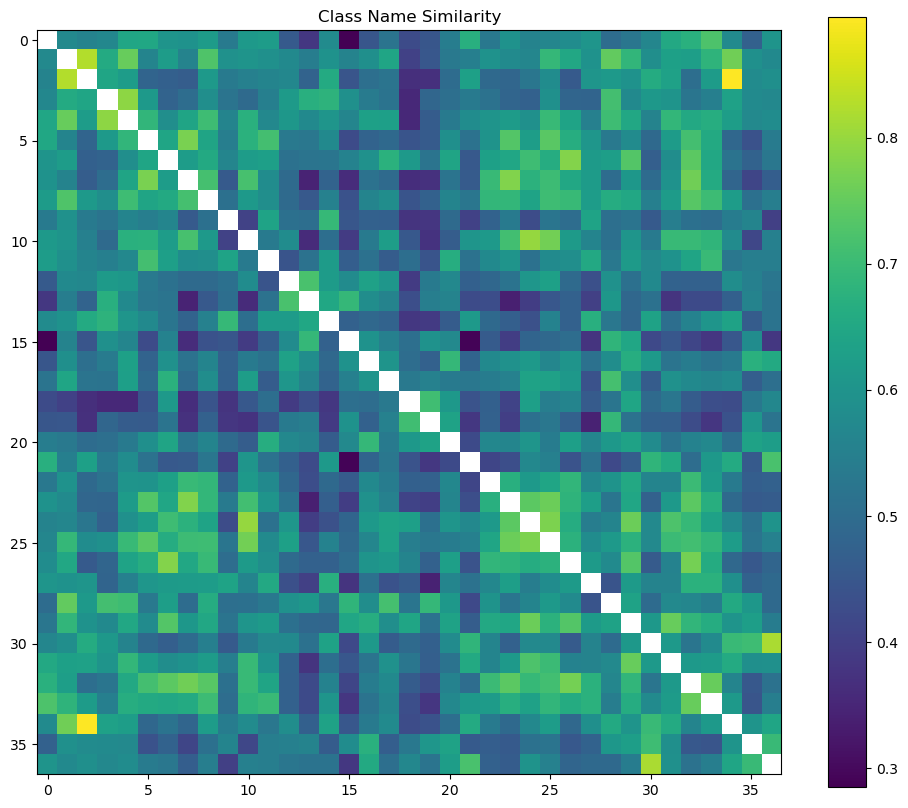

Text template similarity mean: 0.58056640625
Text template similarity std: 0.0989990234375
Rank 1: (2)american_pit_bull_terrier - (34)staffordshire_bull_terrier, similarity: 0.9013671875
Rank 2: (10)chihuahua - (24)pomeranian, similarity: 0.8251953125
Rank 3: (1)american_bulldog - (2)american_pit_bull_terrier, similarity: 0.82177734375
Rank 4: (6)birman - (26)ragdoll, similarity: 0.818359375
Rank 5: (30)scottish_terrier - (36)yorkshire_terrier, similarity: 0.81787109375
Rank 6: (3)basset_hound - (4)beagle, similarity: 0.81689453125
Rank 7: (24)pomeranian - (29)samoyed, similarity: 0.79345703125
Rank 8: (7)bombay - (23)persian, similarity: 0.79345703125
Rank 9: (1)american_bulldog - (8)boxer, similarity: 0.79345703125
Rank 10: (6)birman - (32)siamese, similarity: 0.7890625


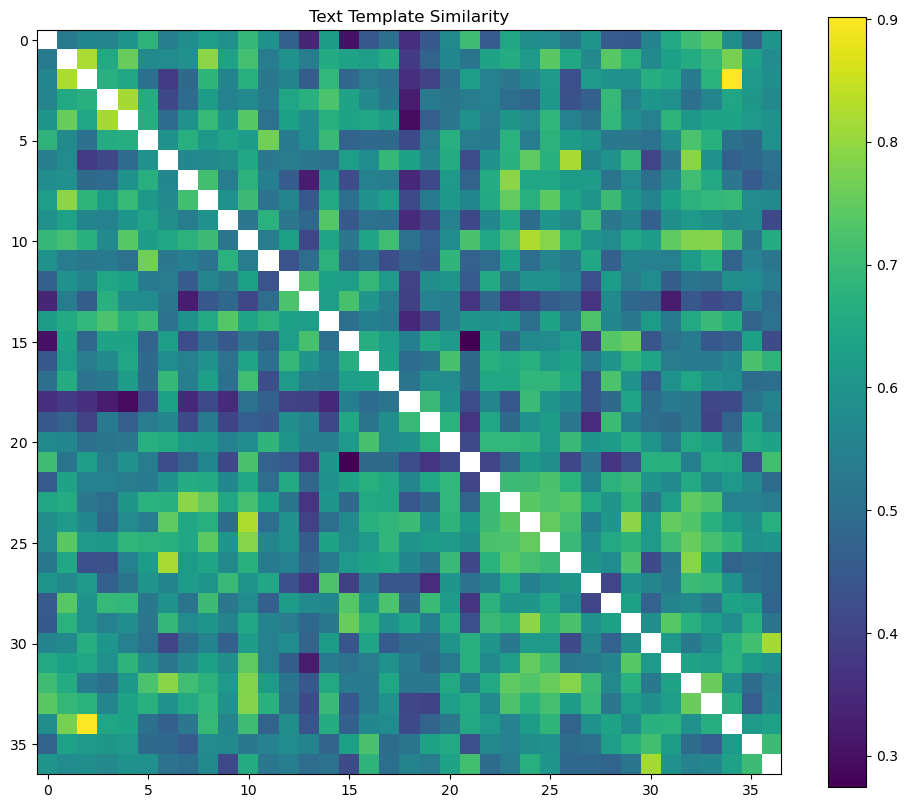

Original gpt-3 text similarity mean: 0.6181640625
Original gpt-3 text similarity std: 0.09503173828125
Rank 1: (2)american_pit_bull_terrier - (34)staffordshire_bull_terrier, similarity: 0.93017578125
Rank 2: (1)american_bulldog - (2)american_pit_bull_terrier, similarity: 0.90283203125
Rank 3: (15)great_pyrenees - (29)samoyed, similarity: 0.8681640625
Rank 4: (6)birman - (26)ragdoll, similarity: 0.861328125
Rank 5: (1)american_bulldog - (34)staffordshire_bull_terrier, similarity: 0.8564453125
Rank 6: (2)american_pit_bull_terrier - (8)boxer, similarity: 0.85205078125
Rank 7: (1)american_bulldog - (8)boxer, similarity: 0.84716796875
Rank 8: (10)chihuahua - (24)pomeranian, similarity: 0.8408203125
Rank 9: (3)basset_hound - (4)beagle, similarity: 0.83740234375
Rank 10: (30)scottish_terrier - (36)yorkshire_terrier, similarity: 0.81591796875


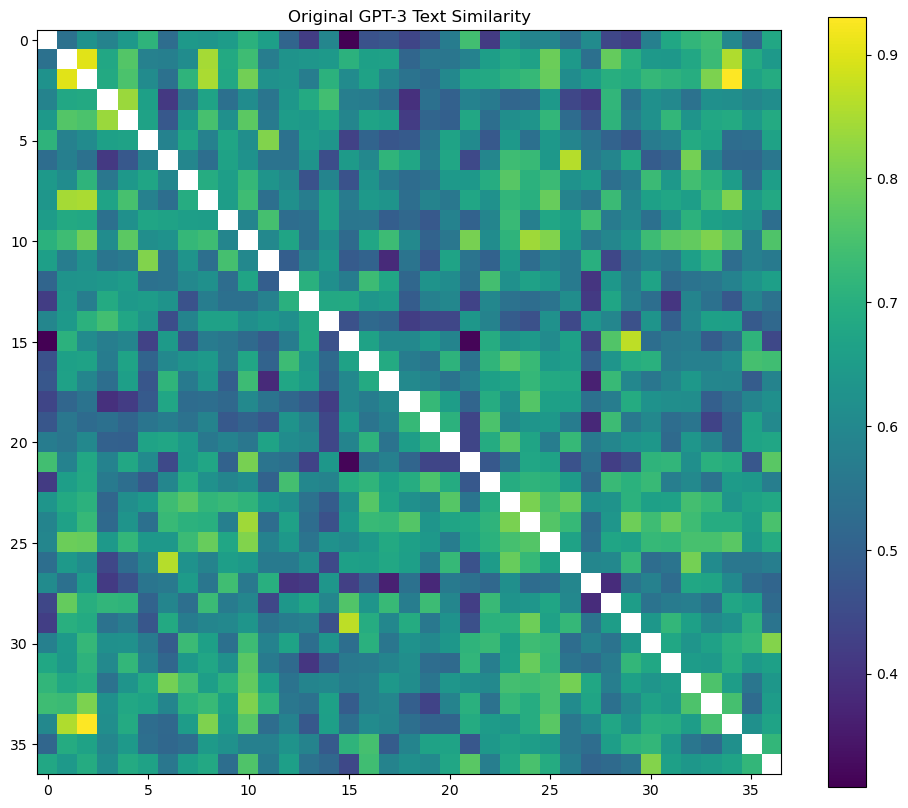

Filtered gpt-3 text similarity mean: 0.6142578125
Filtered gpt-3 text similarity std: 0.09661865234375
Rank 1: (2)american_pit_bull_terrier - (34)staffordshire_bull_terrier, similarity: 0.9306640625
Rank 2: (1)american_bulldog - (2)american_pit_bull_terrier, similarity: 0.90283203125
Rank 3: (15)great_pyrenees - (29)samoyed, similarity: 0.87060546875
Rank 4: (6)birman - (26)ragdoll, similarity: 0.861328125
Rank 5: (1)american_bulldog - (34)staffordshire_bull_terrier, similarity: 0.85693359375
Rank 6: (2)american_pit_bull_terrier - (8)boxer, similarity: 0.85205078125
Rank 7: (1)american_bulldog - (8)boxer, similarity: 0.84716796875
Rank 8: (10)chihuahua - (24)pomeranian, similarity: 0.8408203125
Rank 9: (3)basset_hound - (4)beagle, similarity: 0.83740234375
Rank 10: (30)scottish_terrier - (36)yorkshire_terrier, similarity: 0.81787109375


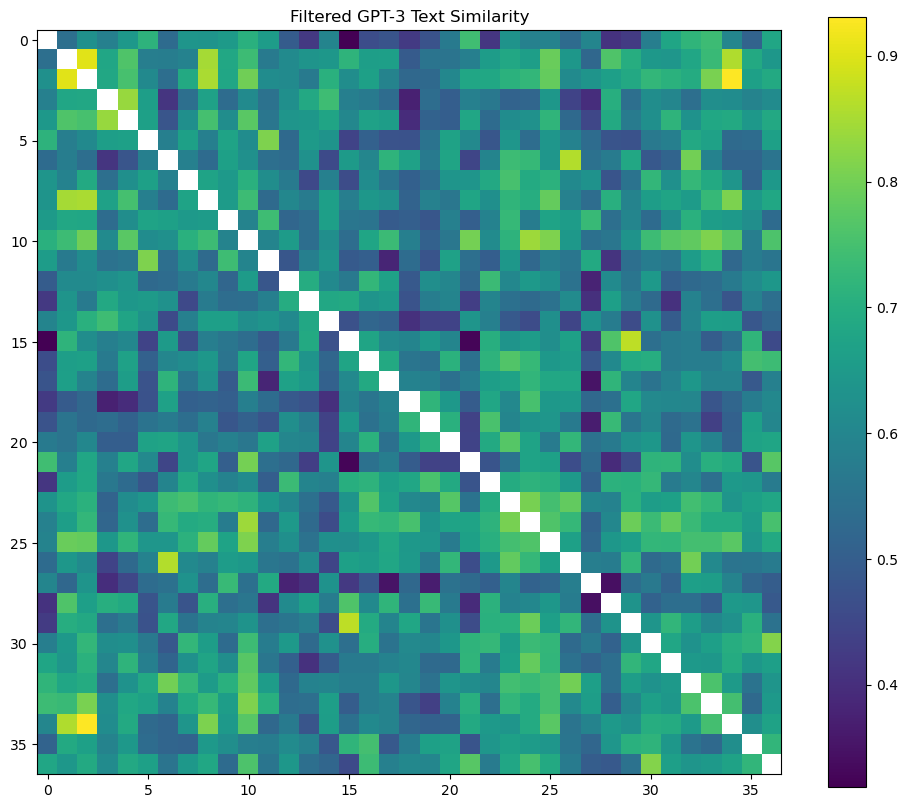

In [36]:
# Auto-similarity of text features
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name')
visualize_auto_similarity(template_masked_similarity, 'Text Template')
visualize_auto_similarity(original_gpt3_masked_similarity, 'Original GPT-3 Text')
visualize_auto_similarity(filtered_gpt3_masked_similarity, 'Filtered GPT-3 Text')

Image similarity mean: 0.87841796875
Image similarity std: 0.048126220703125
Rank 1: (6)birman - (26)ragdoll, similarity: 0.98779296875
Rank 2: (12)english_cocker_spaniel - (13)english_setter, similarity: 0.9794921875
Rank 3: (6)birman - (32)siamese, similarity: 0.97705078125
Rank 4: (1)american_bulldog - (8)boxer, similarity: 0.9765625
Rank 5: (9)british_shorthair - (27)russian_blue, similarity: 0.9755859375
Rank 6: (2)american_pit_bull_terrier - (34)staffordshire_bull_terrier, similarity: 0.97509765625
Rank 7: (5)bengal - (11)egyptian_mau, similarity: 0.9736328125
Rank 8: (10)chihuahua - (21)miniature_pinscher, similarity: 0.9736328125
Rank 9: (19)leonberger - (22)newfoundland, similarity: 0.97314453125
Rank 10: (16)havanese - (36)yorkshire_terrier, similarity: 0.97314453125


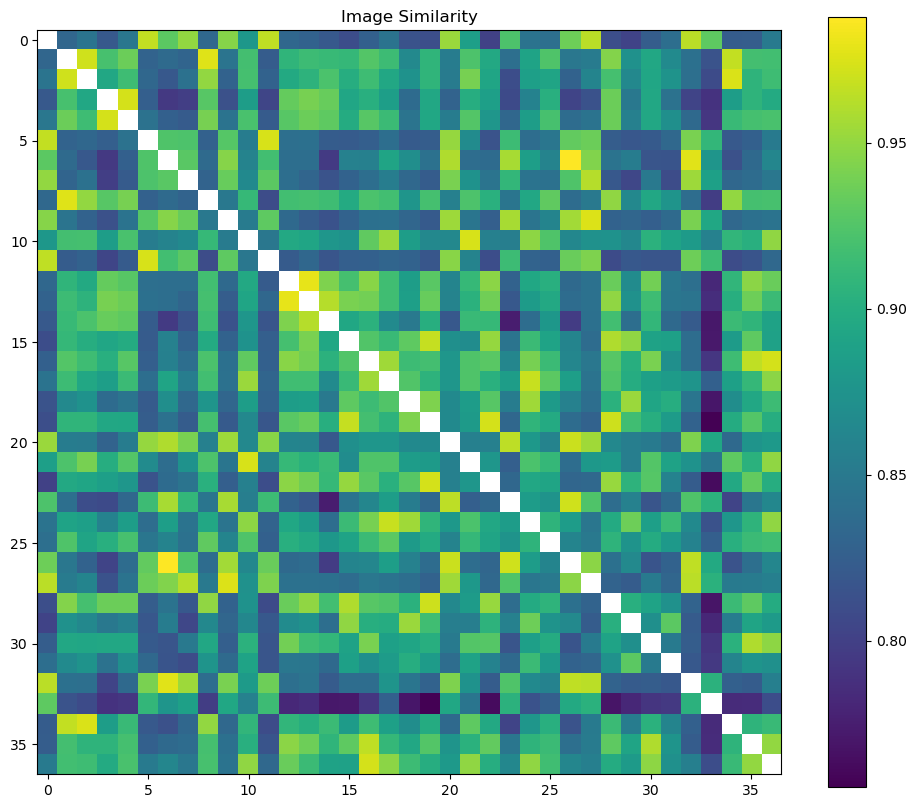

Image to class name similarity mean: 0.203369140625
Image to class name similarity std: 0.0391845703125
Image to class name similarity diagonal mean: 0.307861328125
Image to class name similarity diagonal std: 0.0240936279296875
Image to class name similarity non-diagonal mean: 0.200439453125
Image to class name similarity non-diagonal std: 0.035369873046875
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.5361328125
Rank 1: (26)(Image)ragdoll - (6)(Text)birman, similarity: 0.302978515625
Rank 2: (9)(Image)british_shorthair - (27)(Text)russian_blue, similarity: 0.302734375
Rank 3: (6)(Image)birman - (26)(Text)ragdoll, similarity: 0.302001953125
Rank 4: (13)(Image)english_setter - (12)(Text)english_cocker_spaniel, similarity: 0.299560546875
Rank 5: (34)(Image)staffordshire_bull_terrier - (2)(Text)american_pit_bull_terrier, similarity: 0.292236328125
Rank 6: (11)(Image)egyptian_mau - (5)(Text)bengal, similarity: 0.291748046875
Rank 7: (5)(Image)bengal - (11)(Tex

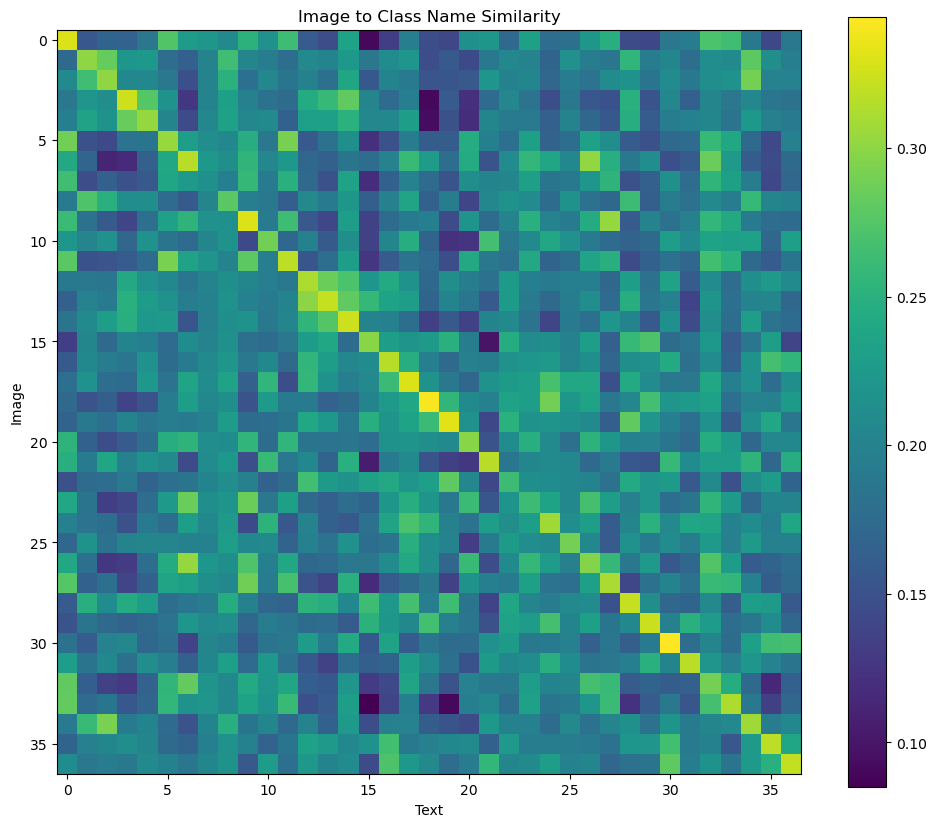

Rank 1: (26)(Image)ragdoll - (6)(Text)birman, error rate: 0.64
Rank 2: (22)(Image)newfoundland - (19)(Text)leonberger, error rate: 0.53
Rank 3: (23)(Image)persian - (9)(Text)british_shorthair, error rate: 0.46
Rank 4: (7)(Image)bombay - (0)(Text)abyssinian, error rate: 0.45454545454545453
Rank 5: (23)(Image)persian - (6)(Text)birman, error rate: 0.39
Rank 6: (32)(Image)siamese - (6)(Text)birman, error rate: 0.34
Rank 7: (32)(Image)siamese - (0)(Text)abyssinian, error rate: 0.3
Rank 8: (7)(Image)bombay - (9)(Text)british_shorthair, error rate: 0.29545454545454547
Rank 9: (8)(Image)boxer - (1)(Text)american_bulldog, error rate: 0.26262626262626265
Rank 10: (22)(Image)newfoundland - (12)(Text)english_cocker_spaniel, error rate: 0.25
Rank 11: (5)(Image)bengal - (0)(Text)abyssinian, error rate: 0.21
Rank 12: (5)(Image)bengal - (11)(Text)egyptian_mau, error rate: 0.16
Rank 13: (13)(Image)english_setter - (12)(Text)english_cocker_spaniel, error rate: 0.15
Rank 14: (10)(Image)chihuahua - (21)(

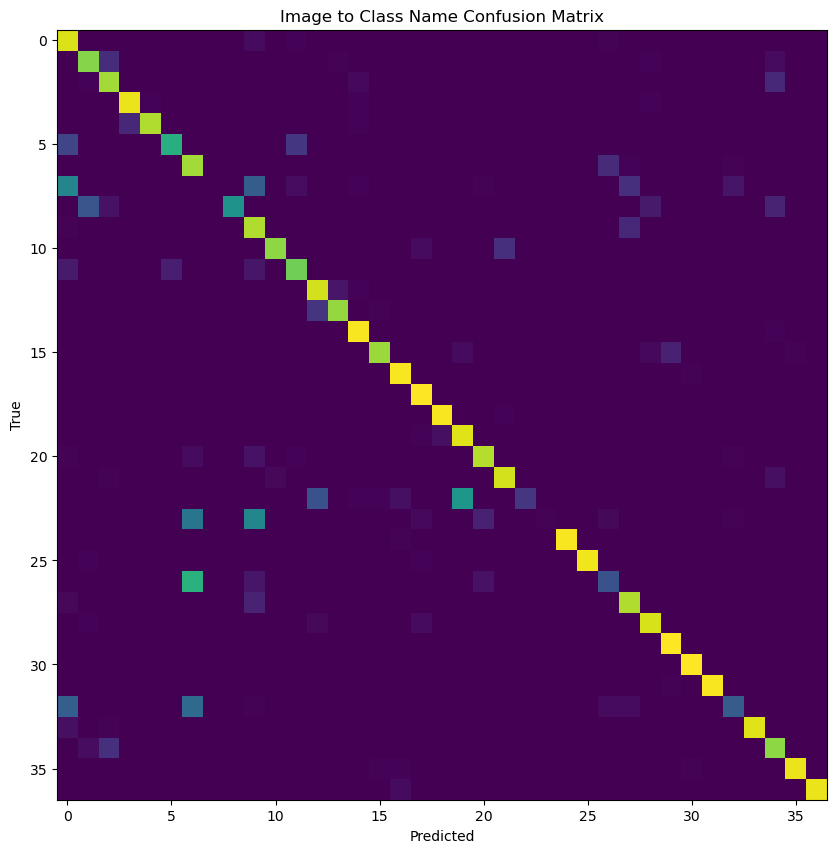

Image to text template (centroid) similarity mean: 0.2137451171875
Image to text template (centroid) similarity std: 0.044219970703125
Image to text template (centroid) similarity diagonal mean: 0.33154296875
Image to text template (centroid) similarity diagonal std: 0.02081298828125
Image to text template (centroid) similarity non-diagonal mean: 0.21044921875
Image to text template (centroid) similarity non-diagonal std: 0.040008544921875
Image to text template (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.5751953125
Rank 1: (6)(Image)birman - (26)(Text)ragdoll, similarity: 0.33154296875
Rank 2: (26)(Image)ragdoll - (6)(Text)birman, similarity: 0.328857421875
Rank 3: (6)(Image)birman - (32)(Text)siamese, similarity: 0.319091796875
Rank 4: (18)(Image)keeshond - (24)(Text)pomeranian, similarity: 0.3173828125
Rank 5: (11)(Image)egyptian_mau - (5)(Text)bengal, similarity: 0.316162109375
Rank 6: (9)(Image)british_shorthair - (27)(Text)russian_blue, similarity: 0.3139648

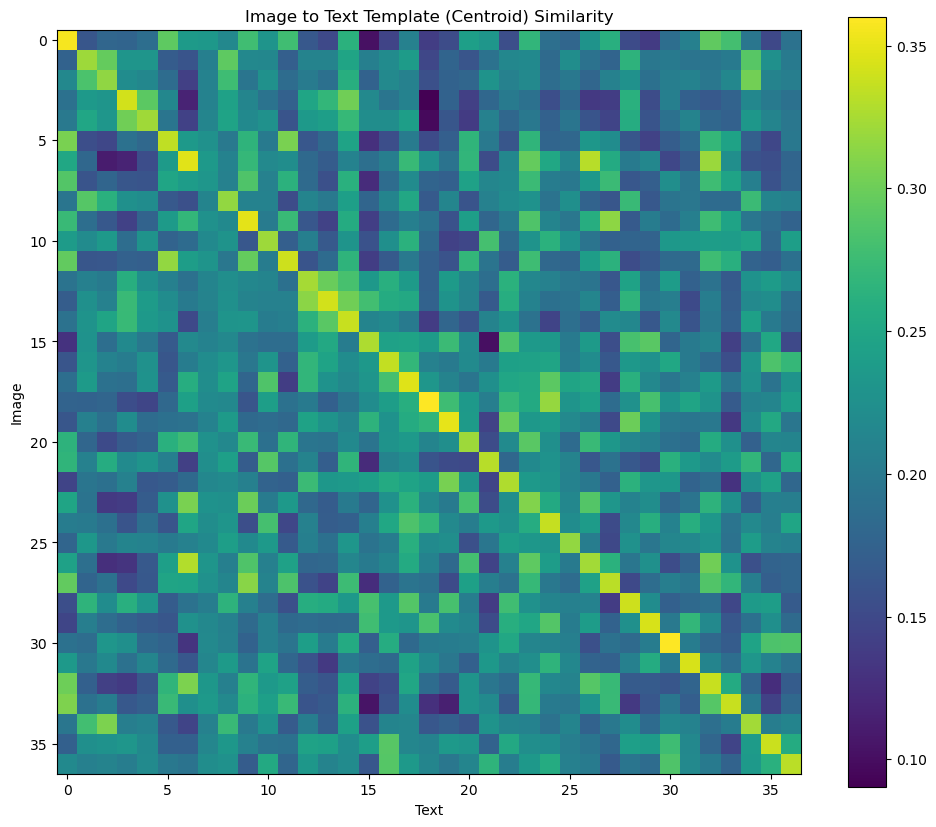

Rank 1: (26)(Image)ragdoll - (6)(Text)birman, error rate: 0.63
Rank 2: (7)(Image)bombay - (0)(Text)abyssinian, error rate: 0.48863636363636365
Rank 3: (7)(Image)bombay - (9)(Text)british_shorthair, error rate: 0.375
Rank 4: (23)(Image)persian - (6)(Text)birman, error rate: 0.27
Rank 5: (34)(Image)staffordshire_bull_terrier - (2)(Text)american_pit_bull_terrier, error rate: 0.20224719101123595
Rank 6: (23)(Image)persian - (9)(Text)british_shorthair, error rate: 0.19
Rank 7: (22)(Image)newfoundland - (19)(Text)leonberger, error rate: 0.17
Rank 8: (11)(Image)egyptian_mau - (5)(Text)bengal, error rate: 0.12371134020618557
Rank 9: (4)(Image)beagle - (3)(Text)basset_hound, error rate: 0.12
Rank 10: (5)(Image)bengal - (0)(Text)abyssinian, error rate: 0.12
Rank 11: (2)(Image)american_pit_bull_terrier - (34)(Text)staffordshire_bull_terrier, error rate: 0.09
Rank 12: (27)(Image)russian_blue - (9)(Text)british_shorthair, error rate: 0.09
Rank 13: (32)(Image)siamese - (6)(Text)birman, error rate: 0

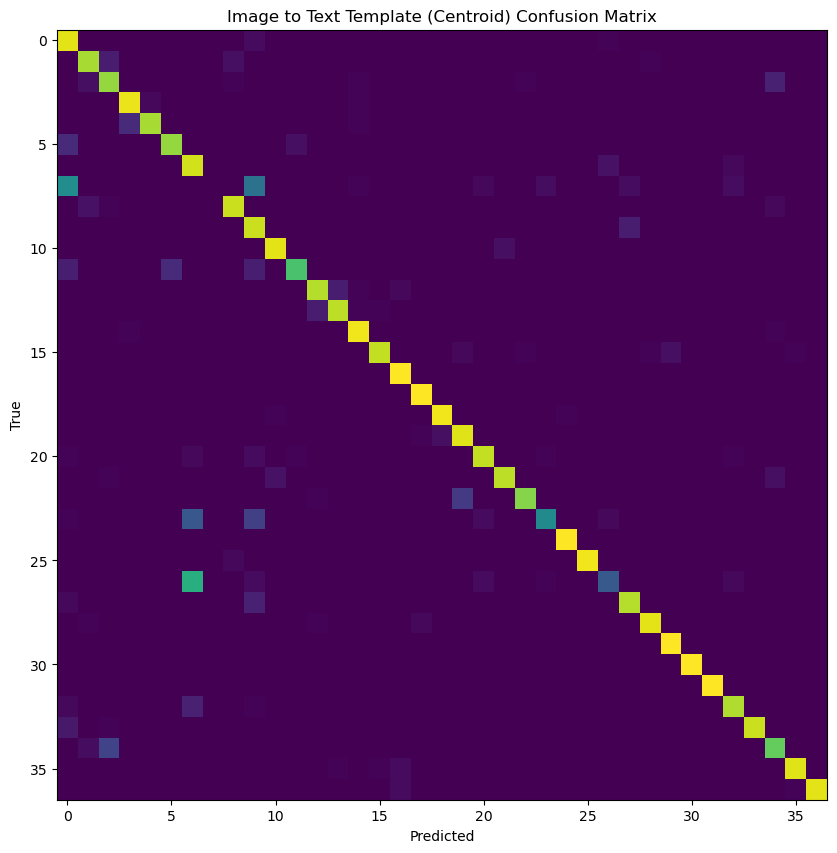

Image to text template (individual avg) similarity mean: 0.1942533254623413
Image to text template (individual avg) similarity std: 0.03992689773440361
Image to text template (individual avg) similarity diagonal mean: 0.30158624053001404
Image to text template (individual avg) similarity diagonal std: 0.019928060472011566
Image to text template (individual avg) similarity non-diagonal mean: 0.1912718564271927
Image to text template (individual avg) similarity non-diagonal std: 0.036034829914569855
Image to text template (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.576741337776184
Rank 1: (6)(Image)birman - (26)(Text)ragdoll, similarity: 0.301513671875
Rank 2: (26)(Image)ragdoll - (6)(Text)birman, similarity: 0.298828125
Rank 3: (9)(Image)british_shorthair - (27)(Text)russian_blue, similarity: 0.28955078125
Rank 4: (13)(Image)english_setter - (12)(Text)english_cocker_spaniel, similarity: 0.2880859375
Rank 5: (18)(Image)keeshond - (24)(Text)pomeranian, similari

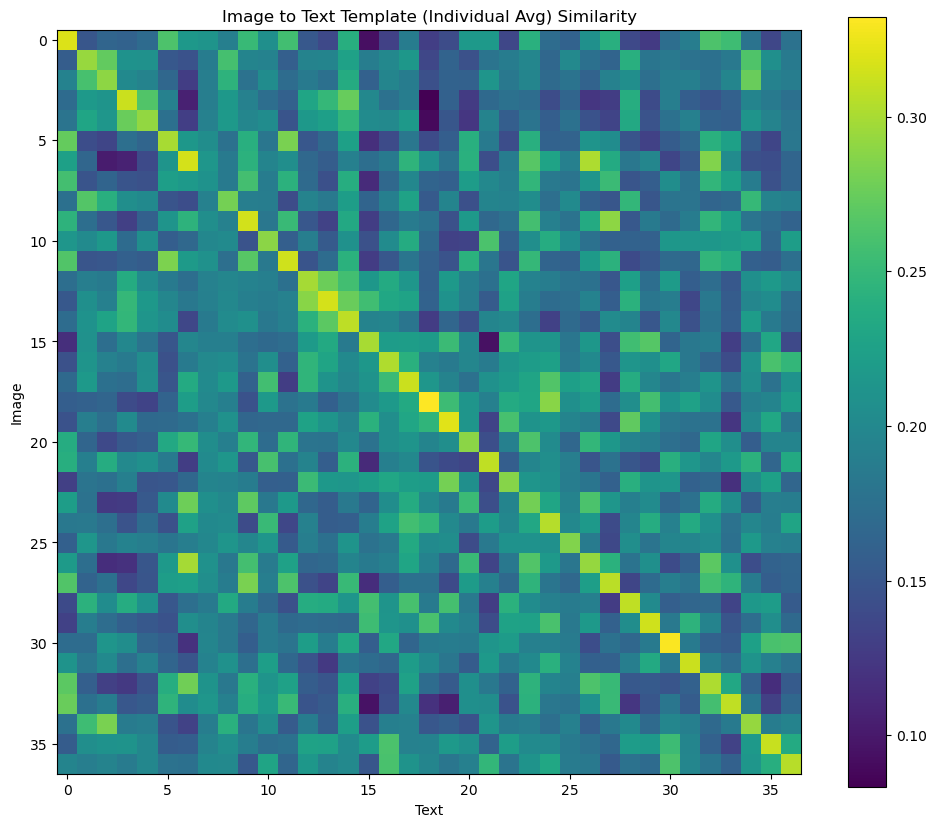

Rank 1: (26)(Image)ragdoll - (6)(Text)birman, error rate: 0.64
Rank 2: (7)(Image)bombay - (0)(Text)abyssinian, error rate: 0.4318181818181818
Rank 3: (7)(Image)bombay - (9)(Text)british_shorthair, error rate: 0.375
Rank 4: (22)(Image)newfoundland - (19)(Text)leonberger, error rate: 0.37
Rank 5: (23)(Image)persian - (6)(Text)birman, error rate: 0.3
Rank 6: (34)(Image)staffordshire_bull_terrier - (2)(Text)american_pit_bull_terrier, error rate: 0.23595505617977527
Rank 7: (23)(Image)persian - (9)(Text)british_shorthair, error rate: 0.18
Rank 8: (4)(Image)beagle - (3)(Text)basset_hound, error rate: 0.15
Rank 9: (8)(Image)boxer - (1)(Text)american_bulldog, error rate: 0.1414141414141414
Rank 10: (32)(Image)siamese - (6)(Text)birman, error rate: 0.14
Rank 11: (5)(Image)bengal - (0)(Text)abyssinian, error rate: 0.12
Rank 12: (7)(Image)bombay - (27)(Text)russian_blue, error rate: 0.11363636363636363
Rank 13: (9)(Image)british_shorthair - (27)(Text)russian_blue, error rate: 0.11
Rank 14: (1)(Im

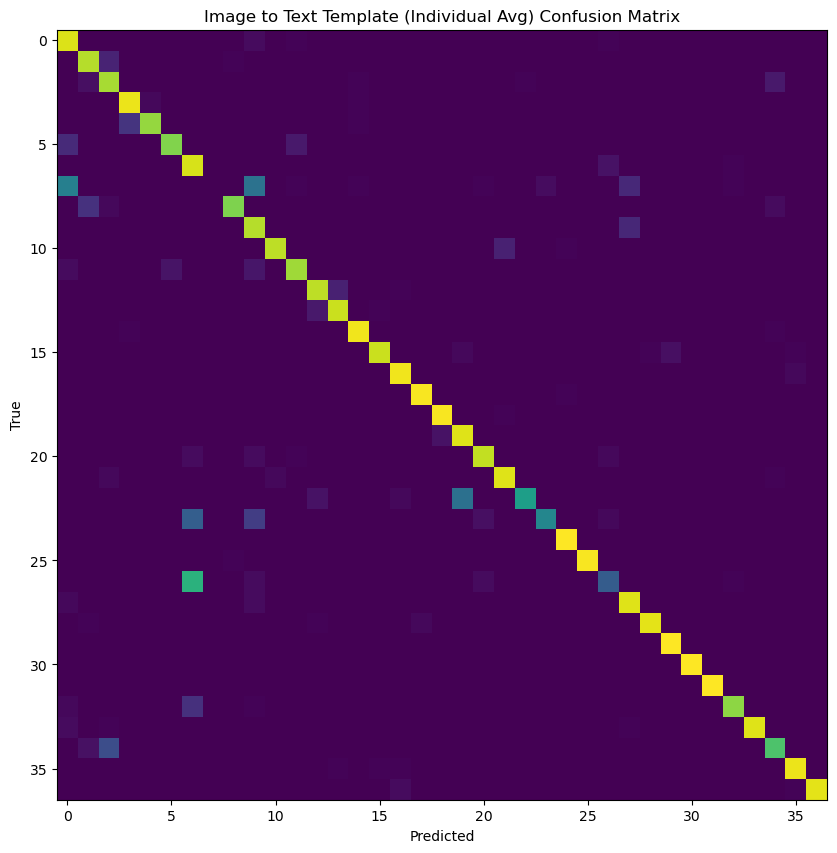

Image to original gpt-3 text (centroid) similarity mean: 0.218994140625
Image to original gpt-3 text (centroid) similarity std: 0.045501708984375
Image to original gpt-3 text (centroid) similarity diagonal mean: 0.34130859375
Image to original gpt-3 text (centroid) similarity diagonal std: 0.0110931396484375
Image to original gpt-3 text (centroid) similarity non-diagonal mean: 0.2156982421875
Image to original gpt-3 text (centroid) similarity non-diagonal std: 0.04119873046875
Image to original gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.58203125
Rank 1: (6)(Image)birman - (26)(Text)ragdoll, similarity: 0.345703125
Rank 2: (6)(Image)birman - (32)(Text)siamese, similarity: 0.33740234375
Rank 3: (26)(Image)ragdoll - (6)(Text)birman, similarity: 0.334228515625
Rank 4: (9)(Image)british_shorthair - (27)(Text)russian_blue, similarity: 0.3251953125
Rank 5: (26)(Image)ragdoll - (32)(Text)siamese, similarity: 0.322998046875
Rank 6: (19)(Image)leonberger - (22)(

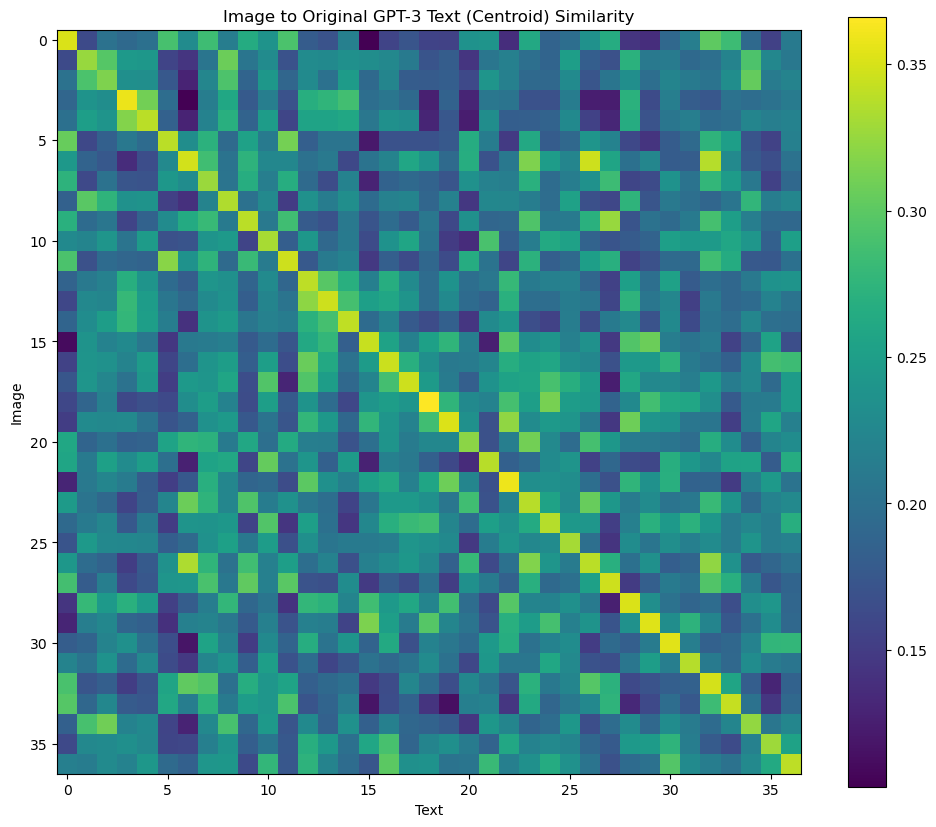

Rank 1: (6)(Image)birman - (26)(Text)ragdoll, error rate: 0.28
Rank 2: (26)(Image)ragdoll - (6)(Text)birman, error rate: 0.27
Rank 3: (9)(Image)british_shorthair - (27)(Text)russian_blue, error rate: 0.24
Rank 4: (20)(Image)maine_coon - (23)(Text)persian, error rate: 0.18
Rank 5: (6)(Image)birman - (32)(Text)siamese, error rate: 0.18
Rank 6: (1)(Image)american_bulldog - (8)(Text)boxer, error rate: 0.15
Rank 7: (26)(Image)ragdoll - (32)(Text)siamese, error rate: 0.13
Rank 8: (2)(Image)american_pit_bull_terrier - (34)(Text)staffordshire_bull_terrier, error rate: 0.13
Rank 9: (11)(Image)egyptian_mau - (5)(Text)bengal, error rate: 0.1134020618556701
Rank 10: (5)(Image)bengal - (0)(Text)abyssinian, error rate: 0.11
Rank 11: (4)(Image)beagle - (3)(Text)basset_hound, error rate: 0.09
Rank 12: (34)(Image)staffordshire_bull_terrier - (2)(Text)american_pit_bull_terrier, error rate: 0.0898876404494382
Rank 13: (21)(Image)miniature_pinscher - (10)(Text)chihuahua, error rate: 0.08
Rank 14: (13)(Ima

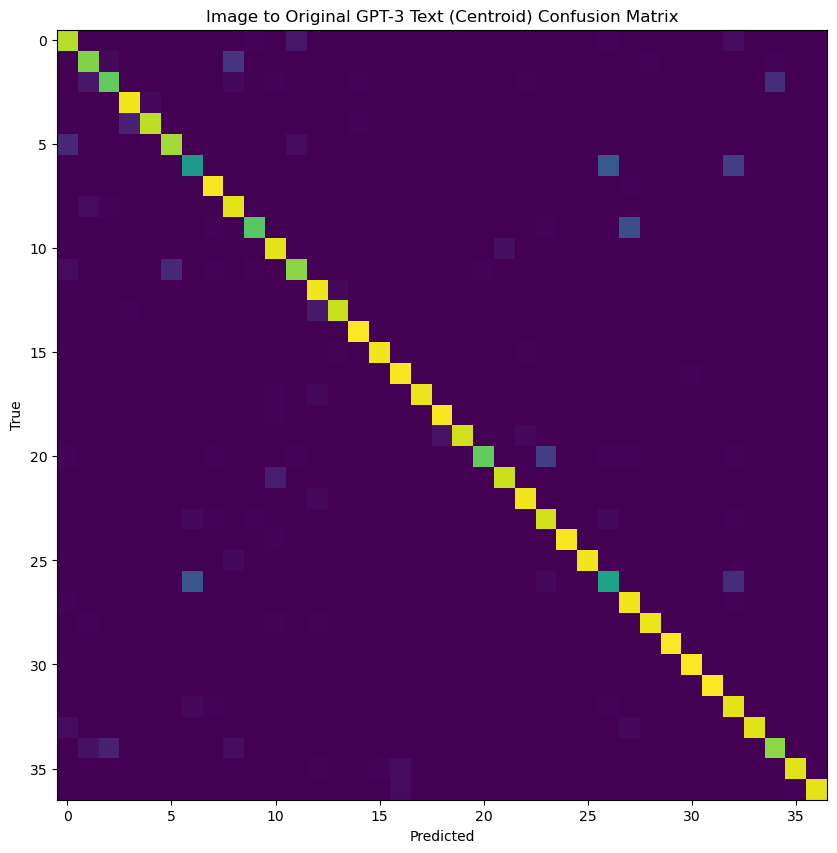

Image to original gpt-3 text (individual avg) similarity mean: 0.21151557564735413
Image to original gpt-3 text (individual avg) similarity std: 0.04370562359690666
Image to original gpt-3 text (individual avg) similarity diagonal mean: 0.32976141571998596
Image to original gpt-3 text (individual avg) similarity diagonal std: 0.0109843285754323
Image to original gpt-3 text (individual avg) similarity non-diagonal mean: 0.20823097229003906
Image to original gpt-3 text (individual avg) similarity non-diagonal std: 0.03950583189725876
Image to original gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.5836329460144043
Rank 1: (6)(Image)birman - (26)(Text)ragdoll, similarity: 0.330810546875
Rank 2: (26)(Image)ragdoll - (6)(Text)birman, similarity: 0.32568359375
Rank 3: (6)(Image)birman - (32)(Text)siamese, similarity: 0.322998046875
Rank 4: (9)(Image)british_shorthair - (27)(Text)russian_blue, similarity: 0.3115234375
Rank 5: (4)(Image)beagle - (3)(Text)bas

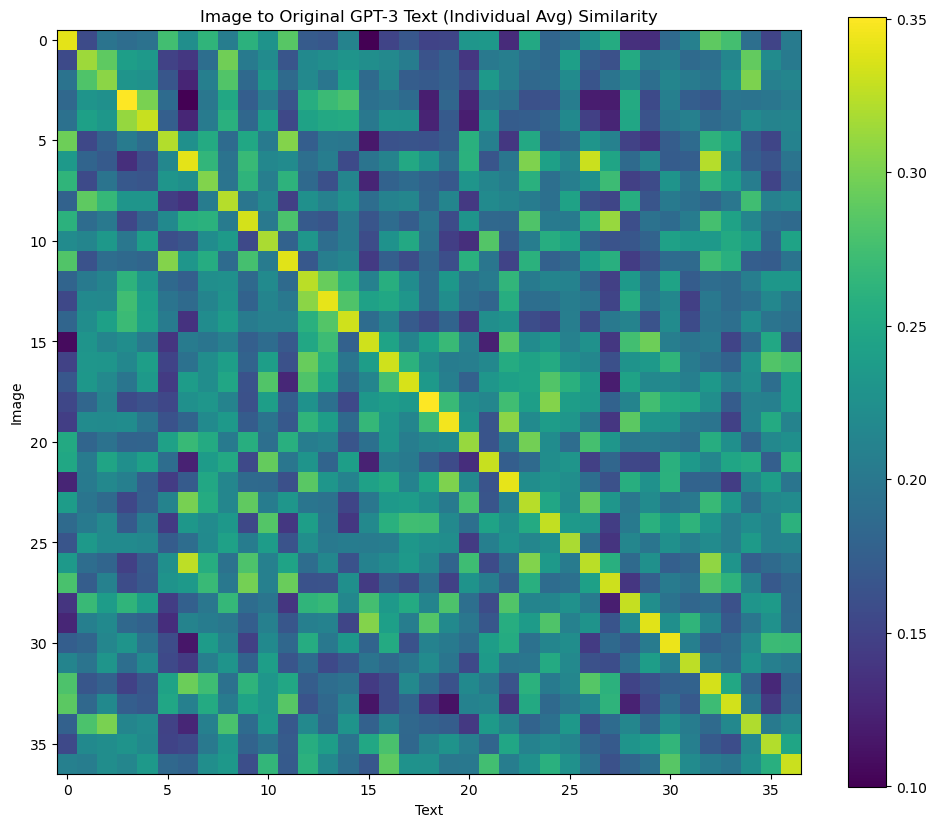

Rank 1: (26)(Image)ragdoll - (6)(Text)birman, error rate: 0.53
Rank 2: (2)(Image)american_pit_bull_terrier - (34)(Text)staffordshire_bull_terrier, error rate: 0.16
Rank 3: (9)(Image)british_shorthair - (27)(Text)russian_blue, error rate: 0.15
Rank 4: (1)(Image)american_bulldog - (8)(Text)boxer, error rate: 0.14
Rank 5: (4)(Image)beagle - (3)(Text)basset_hound, error rate: 0.12
Rank 6: (20)(Image)maine_coon - (23)(Text)persian, error rate: 0.12
Rank 7: (5)(Image)bengal - (0)(Text)abyssinian, error rate: 0.12
Rank 8: (6)(Image)birman - (26)(Text)ragdoll, error rate: 0.11
Rank 9: (6)(Image)birman - (32)(Text)siamese, error rate: 0.08
Rank 10: (5)(Image)bengal - (11)(Text)egyptian_mau, error rate: 0.08
Rank 11: (0)(Image)abyssinian - (11)(Text)egyptian_mau, error rate: 0.061224489795918366
Rank 12: (2)(Image)american_pit_bull_terrier - (1)(Text)american_bulldog, error rate: 0.05
Rank 13: (26)(Image)ragdoll - (32)(Text)siamese, error rate: 0.05
Rank 14: (19)(Image)leonberger - (18)(Text)kee

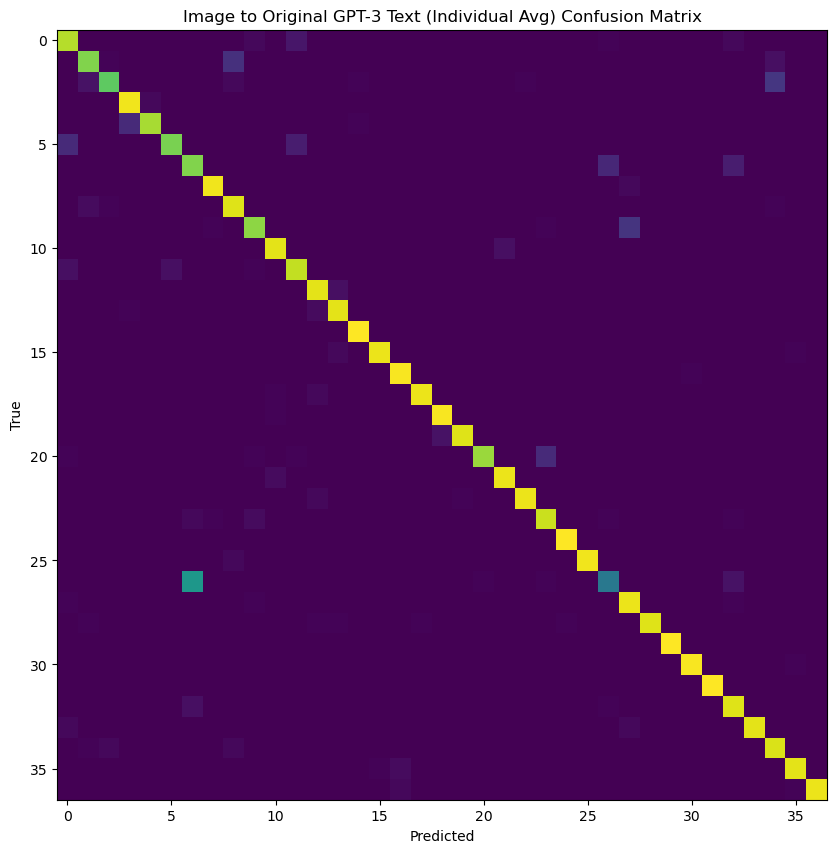

Image to filtered gpt-3 text (centroid) similarity mean: 0.218017578125
Image to filtered gpt-3 text (centroid) similarity std: 0.04571533203125
Image to filtered gpt-3 text (centroid) similarity diagonal mean: 0.3408203125
Image to filtered gpt-3 text (centroid) similarity diagonal std: 0.01055908203125
Image to filtered gpt-3 text (centroid) similarity non-diagonal mean: 0.2147216796875
Image to filtered gpt-3 text (centroid) similarity non-diagonal std: 0.041412353515625
Image to filtered gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.5869140625
Rank 1: (6)(Image)birman - (26)(Text)ragdoll, similarity: 0.345703125
Rank 2: (6)(Image)birman - (32)(Text)siamese, similarity: 0.33740234375
Rank 3: (26)(Image)ragdoll - (6)(Text)birman, similarity: 0.334228515625
Rank 4: (26)(Image)ragdoll - (32)(Text)siamese, similarity: 0.322998046875
Rank 5: (19)(Image)leonberger - (22)(Text)newfoundland, similarity: 0.322509765625
Rank 6: (9)(Image)british_shorthair - (27)

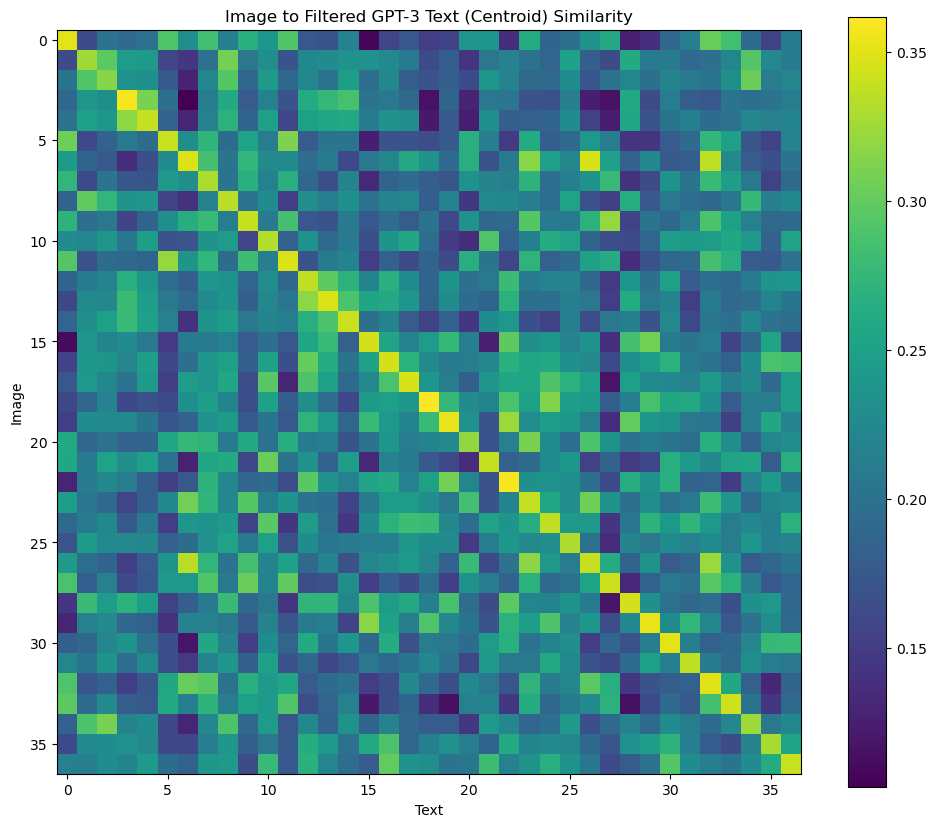

Rank 1: (6)(Image)birman - (26)(Text)ragdoll, error rate: 0.28
Rank 2: (26)(Image)ragdoll - (6)(Text)birman, error rate: 0.27
Rank 3: (20)(Image)maine_coon - (23)(Text)persian, error rate: 0.19
Rank 4: (6)(Image)birman - (32)(Text)siamese, error rate: 0.18
Rank 5: (9)(Image)british_shorthair - (27)(Text)russian_blue, error rate: 0.17
Rank 6: (1)(Image)american_bulldog - (8)(Text)boxer, error rate: 0.15
Rank 7: (26)(Image)ragdoll - (32)(Text)siamese, error rate: 0.13
Rank 8: (2)(Image)american_pit_bull_terrier - (34)(Text)staffordshire_bull_terrier, error rate: 0.12
Rank 9: (11)(Image)egyptian_mau - (5)(Text)bengal, error rate: 0.1134020618556701
Rank 10: (5)(Image)bengal - (0)(Text)abyssinian, error rate: 0.11
Rank 11: (4)(Image)beagle - (3)(Text)basset_hound, error rate: 0.09
Rank 12: (34)(Image)staffordshire_bull_terrier - (2)(Text)american_pit_bull_terrier, error rate: 0.0898876404494382
Rank 13: (21)(Image)miniature_pinscher - (10)(Text)chihuahua, error rate: 0.08
Rank 14: (0)(Imag

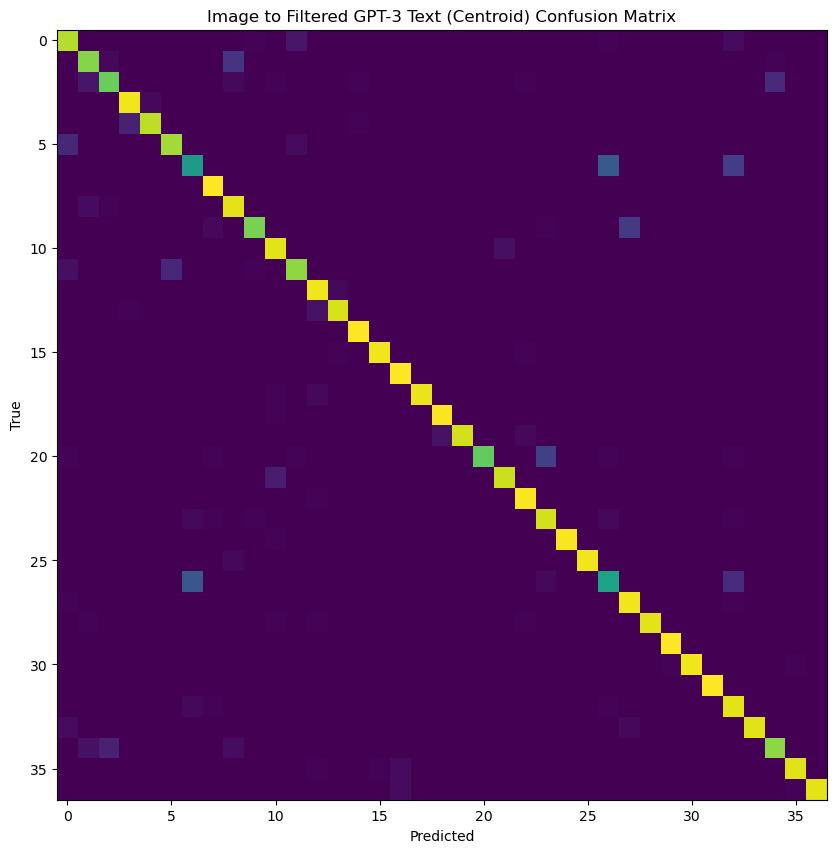

Image to filtered gpt-3 text (individual avg) similarity mean: 0.21134838461875916
Image to filtered gpt-3 text (individual avg) similarity std: 0.04412725195288658
Image to filtered gpt-3 text (individual avg) similarity diagonal mean: 0.33050042390823364
Image to filtered gpt-3 text (individual avg) similarity diagonal std: 0.01068122684955597
Image to filtered gpt-3 text (individual avg) similarity non-diagonal mean: 0.2080385982990265
Image to filtered gpt-3 text (individual avg) similarity non-diagonal std: 0.03991005942225456
Image to filtered gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.5886495113372803
Rank 1: (6)(Image)birman - (26)(Text)ragdoll, similarity: 0.330810546875
Rank 2: (26)(Image)ragdoll - (6)(Text)birman, similarity: 0.32568359375
Rank 3: (6)(Image)birman - (32)(Text)siamese, similarity: 0.322509765625
Rank 4: (9)(Image)british_shorthair - (27)(Text)russian_blue, similarity: 0.3115234375
Rank 5: (4)(Image)beagle - (3)(Text)bas

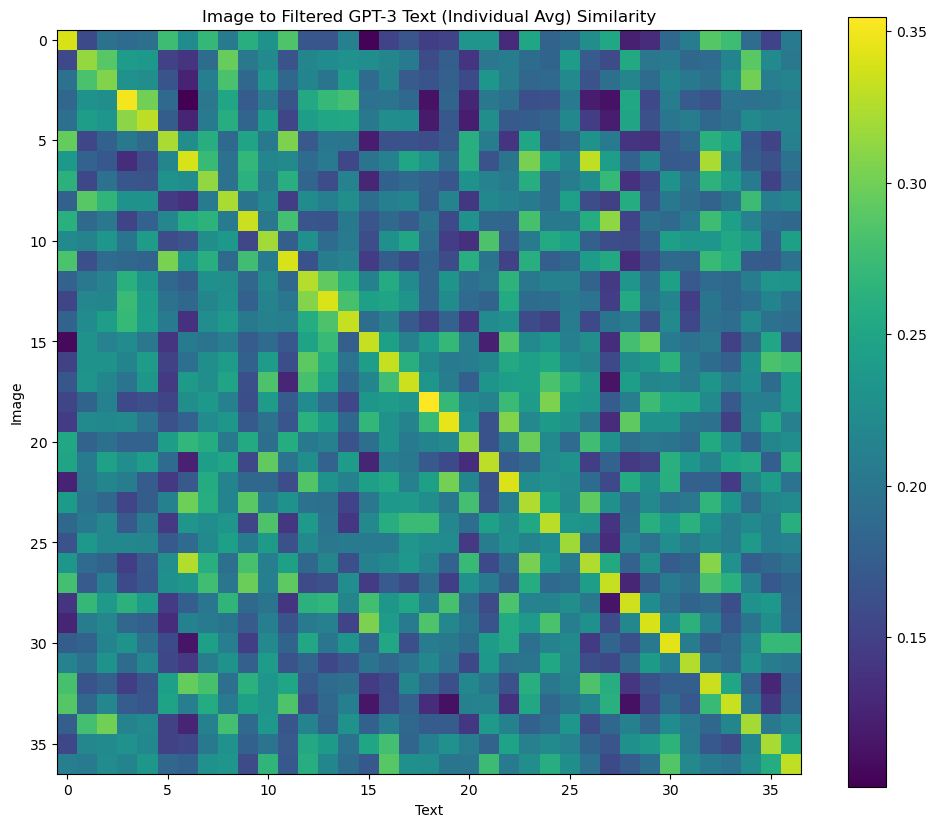

Rank 1: (26)(Image)ragdoll - (6)(Text)birman, error rate: 0.53
Rank 2: (2)(Image)american_pit_bull_terrier - (34)(Text)staffordshire_bull_terrier, error rate: 0.16
Rank 3: (9)(Image)british_shorthair - (27)(Text)russian_blue, error rate: 0.15
Rank 4: (1)(Image)american_bulldog - (8)(Text)boxer, error rate: 0.14
Rank 5: (5)(Image)bengal - (0)(Text)abyssinian, error rate: 0.12
Rank 6: (4)(Image)beagle - (3)(Text)basset_hound, error rate: 0.12
Rank 7: (20)(Image)maine_coon - (23)(Text)persian, error rate: 0.11
Rank 8: (6)(Image)birman - (26)(Text)ragdoll, error rate: 0.11
Rank 9: (6)(Image)birman - (32)(Text)siamese, error rate: 0.08
Rank 10: (5)(Image)bengal - (11)(Text)egyptian_mau, error rate: 0.08
Rank 11: (0)(Image)abyssinian - (11)(Text)egyptian_mau, error rate: 0.061224489795918366
Rank 12: (19)(Image)leonberger - (18)(Text)keeshond, error rate: 0.05
Rank 13: (26)(Image)ragdoll - (32)(Text)siamese, error rate: 0.05
Rank 14: (2)(Image)american_pit_bull_terrier - (1)(Text)american_bu

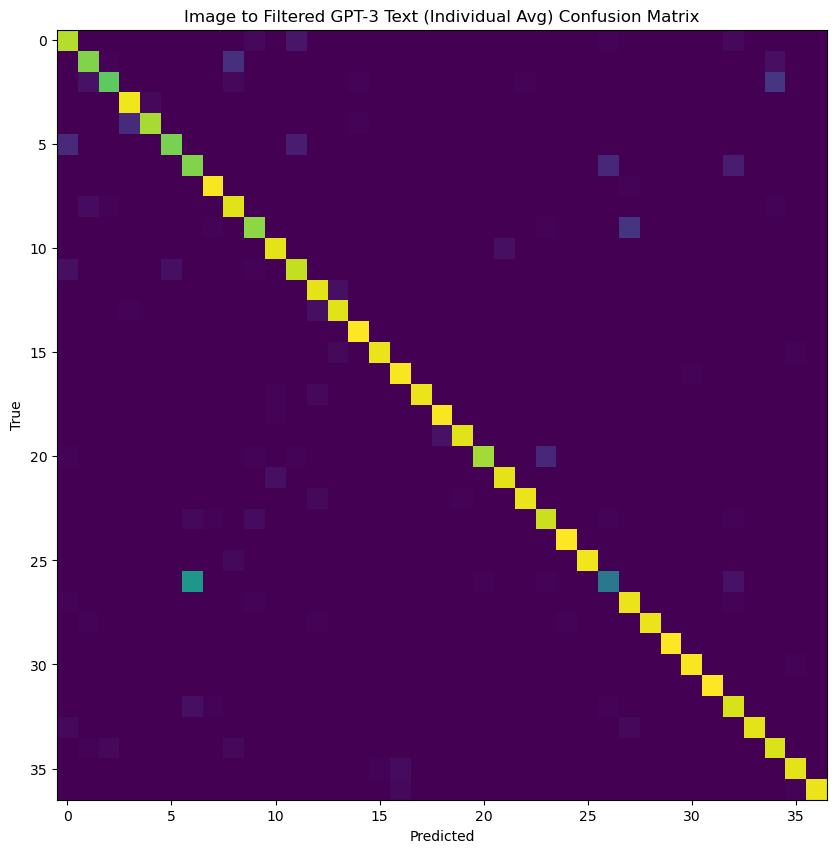

In [37]:
# Auto-similarity of image features
visualize_auto_similarity(img_masked_similarity, 'Image')

# Image to text similarity
visualize_cross_similarity(img_cls_name_similarity, cls_name_cm, 'Image to Class Name')
visualize_cross_similarity(img_template_cls_similarity, template_cls_cm, 'Image to Text Template (Centroid)')
visualize_cross_similarity(img_template_text_similarity, template_text_cm, 'Image to Text Template (Individual Avg)')
visualize_cross_similarity(img_original_gpt3_cls_similarity, original_gpt3_cls_cm, 'Image to Original GPT-3 Text (Centroid)')
visualize_cross_similarity(img_original_gpt3_text_similarity, original_gpt3_text_cm, 'Image to Original GPT-3 Text (Individual Avg)')
visualize_cross_similarity(img_filtered_gpt3_cls_similarity, filtered_gpt3_cls_cm, 'Image to Filtered GPT-3 Text (Centroid)')
visualize_cross_similarity(img_filtered_gpt3_text_similarity, filtered_gpt3_text_cm, 'Image to Filtered GPT-3 Text (Individual Avg)')

In [38]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_gpt3_label_ids, filtered_gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_gpt3_text_features, filtered_gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_start_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_start_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features) + len(filtered_gpt3_text_features)

In [39]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [40]:
def calc_centroid(features, label_ids):
    return [features[label_ids == label_id].mean(axis=0) for label_id in range(len(cls_names_sorted))]

In [41]:
cls_name_transformed_features = transformed_features[cls_name_start_idx:cls_name_end_idx]
cls_name_transformed_label_ids = all_label_ids[cls_name_start_idx:cls_name_end_idx]
cls_name_transformed_centroids = calc_centroid(cls_name_transformed_features, cls_name_transformed_label_ids)
template_transformed_features = transformed_features[template_start_idx:template_end_idx]
template_transformed_label_ids = all_label_ids[template_start_idx:template_end_idx]
template_transformed_centroids = calc_centroid(template_transformed_features, template_transformed_label_ids)
original_gpt3_transformed_features = transformed_features[original_gpt3_start_idx:original_gpt3_end_idx]
original_gpt3_transformed_label_ids = all_label_ids[original_gpt3_start_idx:original_gpt3_end_idx]
original_gpt3_transformed_centroids = calc_centroid(original_gpt3_transformed_features, original_gpt3_transformed_label_ids)
filtered_gpt3_transformed_features = transformed_features[filtered_gpt3_start_idx:filtered_gpt3_end_idx]
filtered_gpt3_transformed_label_ids = all_label_ids[filtered_gpt3_start_idx:filtered_gpt3_end_idx]
filtered_gpt3_transformed_centroids = calc_centroid(filtered_gpt3_transformed_features, filtered_gpt3_transformed_label_ids)

In [42]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.title(title)
    plt.show()

Rank 1: (2)(coor=16,-15)american_pit_bull_terrier - (34)(coor=16,-15)staffordshire_bull_terrier, similarity: 0.8955078125
Rank 2: (1)(coor=8,-12)american_bulldog - (2)(coor=8,-12)american_pit_bull_terrier, similarity: 0.82568359375
Rank 3: (30)(coor=-0,-36)scottish_terrier - (36)(coor=-0,-36)yorkshire_terrier, similarity: 0.818359375
Rank 4: (10)(coor=-2,6)chihuahua - (24)(coor=-2,6)pomeranian, similarity: 0.79931640625
Rank 5: (3)(coor=23,-32)basset_hound - (4)(coor=23,-32)beagle, similarity: 0.79150390625
Rank 6: (6)(coor=1,36)birman - (26)(coor=1,36)ragdoll, similarity: 0.78173828125
Rank 7: (7)(coor=7,17)bombay - (23)(coor=7,17)persian, similarity: 0.78076171875
Rank 8: (24)(coor=-9,6)pomeranian - (25)(coor=-9,6)pug, similarity: 0.77392578125
Rank 9: (5)(coor=17,28)bengal - (7)(coor=17,28)bombay, similarity: 0.77294921875
Rank 10: (26)(coor=-5,33)ragdoll - (32)(coor=-5,33)siamese, similarity: 0.76708984375


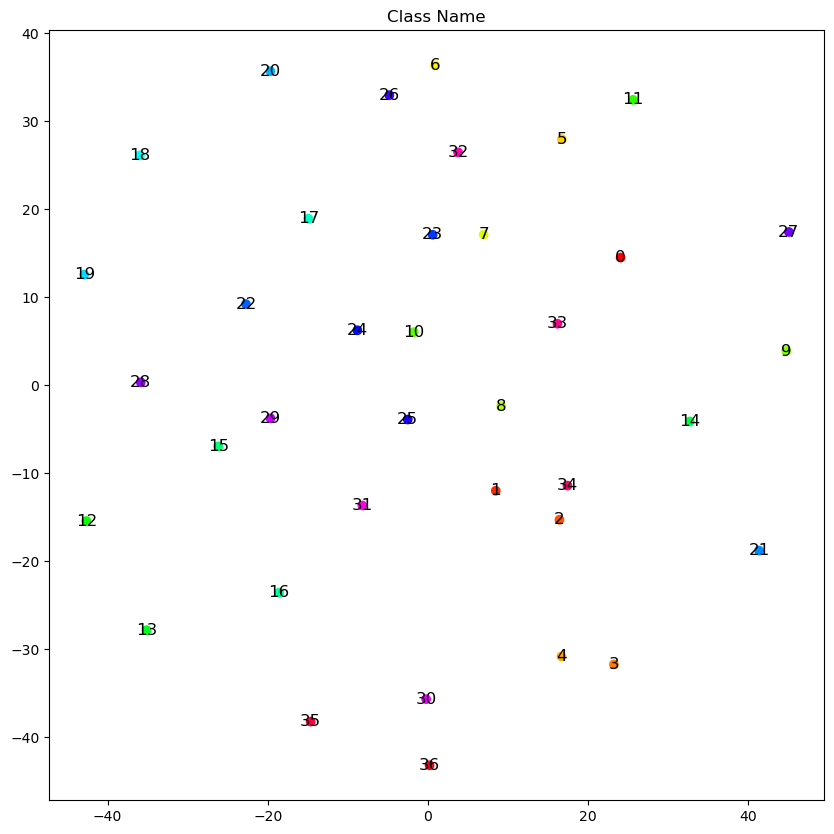

Rank 1: (2)(coor=17,-15)american_pit_bull_terrier - (34)(coor=17,-15)staffordshire_bull_terrier, similarity: 0.9013671875
Rank 2: (10)(coor=-2,5)chihuahua - (24)(coor=-2,5)pomeranian, similarity: 0.8251953125
Rank 3: (1)(coor=8,-13)american_bulldog - (2)(coor=8,-13)american_pit_bull_terrier, similarity: 0.82177734375
Rank 4: (6)(coor=1,37)birman - (26)(coor=1,37)ragdoll, similarity: 0.818359375
Rank 5: (30)(coor=-1,-36)scottish_terrier - (36)(coor=-1,-36)yorkshire_terrier, similarity: 0.81787109375
Rank 6: (3)(coor=24,-32)basset_hound - (4)(coor=24,-32)beagle, similarity: 0.81689453125
Rank 7: (24)(coor=-9,6)pomeranian - (29)(coor=-9,6)samoyed, similarity: 0.79345703125
Rank 8: (7)(coor=7,17)bombay - (23)(coor=7,17)persian, similarity: 0.79345703125
Rank 9: (1)(coor=8,-13)american_bulldog - (8)(coor=8,-13)boxer, similarity: 0.79345703125
Rank 10: (6)(coor=1,37)birman - (32)(coor=1,37)siamese, similarity: 0.7890625


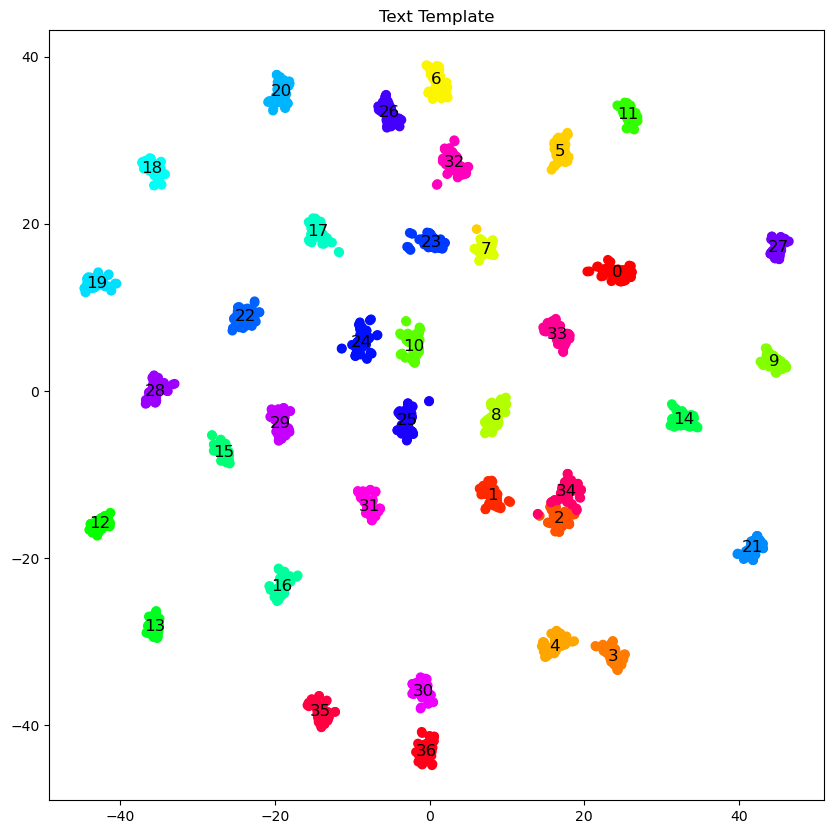

Rank 1: (2)(coor=14,-10)american_pit_bull_terrier - (34)(coor=14,-10)staffordshire_bull_terrier, similarity: 0.93017578125
Rank 2: (1)(coor=9,-11)american_bulldog - (2)(coor=9,-11)american_pit_bull_terrier, similarity: 0.90283203125
Rank 3: (15)(coor=-24,-6)great_pyrenees - (29)(coor=-24,-6)samoyed, similarity: 0.8681640625
Rank 4: (6)(coor=-0,37)birman - (26)(coor=-0,37)ragdoll, similarity: 0.861328125
Rank 5: (1)(coor=9,-11)american_bulldog - (34)(coor=9,-11)staffordshire_bull_terrier, similarity: 0.8564453125
Rank 6: (2)(coor=14,-10)american_pit_bull_terrier - (8)(coor=14,-10)boxer, similarity: 0.85205078125
Rank 7: (1)(coor=9,-11)american_bulldog - (8)(coor=9,-11)boxer, similarity: 0.84716796875
Rank 8: (10)(coor=-0,5)chihuahua - (24)(coor=-0,5)pomeranian, similarity: 0.8408203125
Rank 9: (3)(coor=22,-32)basset_hound - (4)(coor=22,-32)beagle, similarity: 0.83740234375
Rank 10: (30)(coor=1,-35)scottish_terrier - (36)(coor=1,-35)yorkshire_terrier, similarity: 0.81591796875


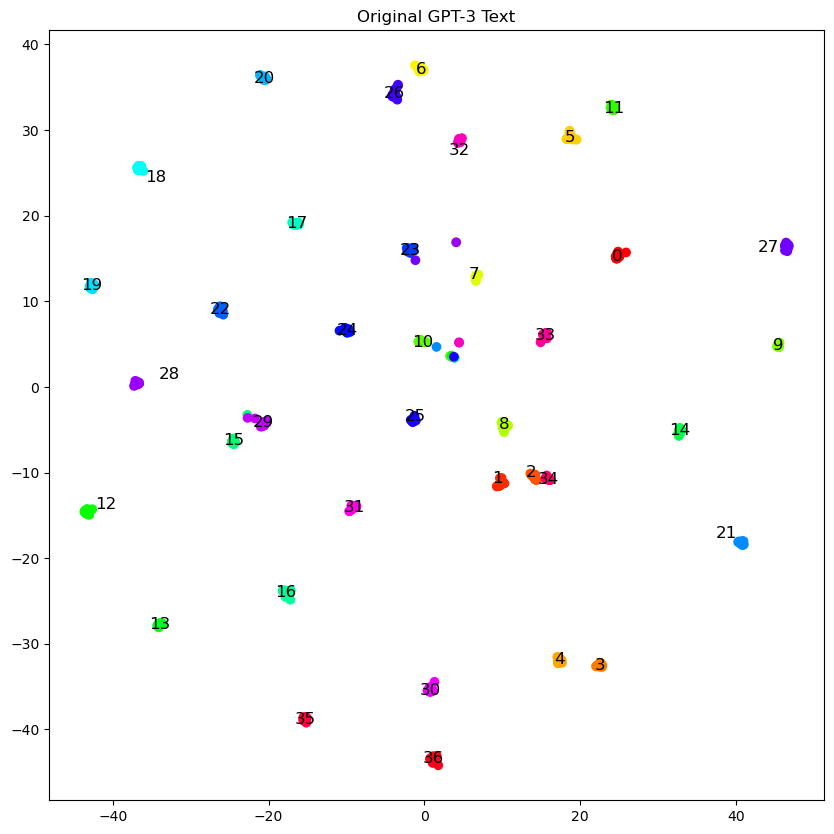

Rank 1: (2)(coor=14,-10)american_pit_bull_terrier - (34)(coor=14,-10)staffordshire_bull_terrier, similarity: 0.9306640625
Rank 2: (1)(coor=9,-11)american_bulldog - (2)(coor=9,-11)american_pit_bull_terrier, similarity: 0.90283203125
Rank 3: (15)(coor=-24,-6)great_pyrenees - (29)(coor=-24,-6)samoyed, similarity: 0.87060546875
Rank 4: (6)(coor=-0,37)birman - (26)(coor=-0,37)ragdoll, similarity: 0.861328125
Rank 5: (1)(coor=9,-11)american_bulldog - (34)(coor=9,-11)staffordshire_bull_terrier, similarity: 0.85693359375
Rank 6: (2)(coor=14,-10)american_pit_bull_terrier - (8)(coor=14,-10)boxer, similarity: 0.85205078125
Rank 7: (1)(coor=9,-11)american_bulldog - (8)(coor=9,-11)boxer, similarity: 0.84716796875
Rank 8: (10)(coor=-0,5)chihuahua - (24)(coor=-0,5)pomeranian, similarity: 0.8408203125
Rank 9: (3)(coor=22,-32)basset_hound - (4)(coor=22,-32)beagle, similarity: 0.83740234375
Rank 10: (30)(coor=1,-35)scottish_terrier - (36)(coor=1,-35)yorkshire_terrier, similarity: 0.81787109375


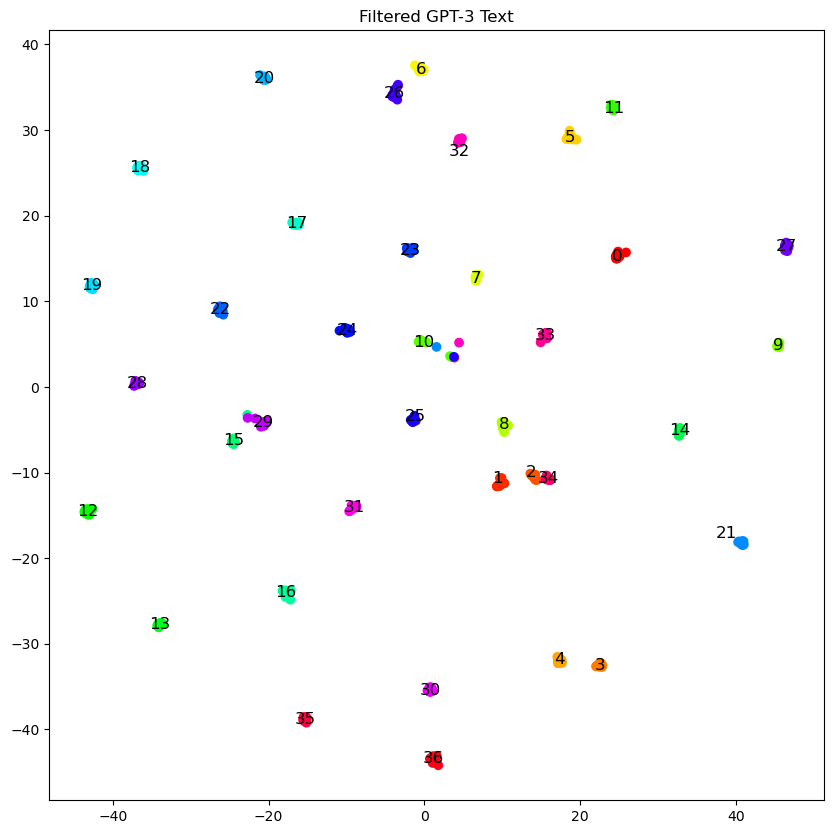

In [43]:
print_top_pairs(np.triu(cls_name_masked_similarity, k=1), 'similarity', coordinates=cls_name_transformed_centroids)
plot_features_2d(cls_name_transformed_features, cls_name_transformed_label_ids, 'Class Name')
print_top_pairs(np.triu(template_masked_similarity, k=1), 'similarity', coordinates=template_transformed_centroids)
plot_features_2d(template_transformed_features, template_transformed_label_ids, 'Text Template')
print_top_pairs(np.triu(original_gpt3_masked_similarity, k=1), 'similarity', coordinates=original_gpt3_transformed_centroids)
plot_features_2d(original_gpt3_transformed_features, original_gpt3_transformed_label_ids, 'Original GPT-3 Text')
print_top_pairs(np.triu(filtered_gpt3_masked_similarity, k=1), 'similarity', coordinates=filtered_gpt3_transformed_centroids)
plot_features_2d(filtered_gpt3_transformed_features, filtered_gpt3_transformed_label_ids, 'Filtered GPT-3 Text')